In [1]:
!pip install tmdbsimple
!pip install python-dateutil
!pip install ggplot
import numpy as np
from ggplot import *
import pandas as pd
import tmdbsimple as tmdb
import time
import datetime
from dateutil import parser
import matplotlib.pyplot as plt
from sklearn import linear_model
import sklearn.datasets as ds
import statsmodels.api as sm
from sklearn.feature_selection import f_regression


    100% |████████████████████████████████| 2.2MB 167kB/s ta 0:00:01    75% |████████████████████████▎       | 1.7MB 158kB/s eta 0:00:04


# TMDb Data Analysis

## Part I: How closely related are a TV show's user rating, genre, and number of seasons?

### Introduction & Hypothesis:
From The Honeymooners to Game of Thrones, television series have been a staple of American culture for nearly seven decades. Some don't last long before falling to the proverbial network axe (Freaks & Geeks, Twin Peaks) and subsequently gain cult followings, while others become major successes for their networks and either shape the genre for years to follow (Seinfeld, Breaking Bad) or become stale after running for a certain number of seasons (Arrow). We'd like to learn more about the latter category of shows, more specifically what separates the shows that sustain greatness from those that lose their touch.

We hypothesize that we can relate a show's rating, genre, and number of seasons together. We believe that "thinker" genres, like Drama, Crime, and Sci-Fi/Fantasy will tend to have shows that have higher user ratings but lower seasons compared to genres like Comedy and Action, which will have lower user ratings but more seasons.

We will test our hypothesis using data from an open source movie database, TMDb, and a python wrapper for it called tmdbsimple, of which a quick demo is shown below.

Steps to test are as follows:
1. Gathering data on shows with more than 200 votes and 4 or more seasons
2. Cleaning and organizing the data in a pandas table
3. Visualizing this data graphically
4. Getting models to predict a show's rating and expected number of seasons

In [2]:
tmdb.API_KEY = '0b6ab414e6fd79648a868782b0750b09'

In [4]:
tv = tmdb.TV(456) #Keep these cells as demo for tmdb api?
info = tv.info()
info #JSON rep of show info

{'backdrop_path': '/f5uNbUC76oowt5mt5J9QlqrIYQ6.jpg',
 'created_by': [{'gender': 2,
   'id': 5741,
   'name': 'Matt Groening',
   'profile_path': '/zYzOuM94hbVmage9XZrQ8daHyoF.jpg'}],
 'episode_run_time': [22],
 'first_air_date': '1989-12-17',
 'genres': [{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}],
 'homepage': 'http://www.thesimpsons.com/',
 'id': 456,
 'in_production': True,
 'languages': ['en'],
 'last_air_date': '2017-12-10',
 'name': 'The Simpsons',
 'networks': [{'id': 19, 'name': 'Fox Broadcasting Company'}],
 'number_of_episodes': 688,
 'number_of_seasons': 29,
 'origin_country': ['US'],
 'original_language': 'en',
 'original_name': 'The Simpsons',
 'overview': 'Set in Springfield, the average American town, the show focuses on the antics and everyday adventures of the Simpson family; Homer, Marge, Bart, Lisa and Maggie, as well as a virtual cast of thousands. Since the beginning, the series has been a pop culture icon, attracting hundreds of celebrities to 

In [5]:
genres = info.get('genres')

In [6]:
for x in genres:
    print(x['name'])

Animation
Comedy


### Data Collection
Here we scrape data from shows which are 4+ seasons long and 200+ user votes. Collection of data took a while both because the TMDb API only allows 240 requests/min - which was accounted for by "sleeping" our process after each API call - and because we didn't have any way to get a good range of TV ids that TMDb uses to index TV shows, so we didn't come across many shows in the first 30000 possible ids that matched our criteria. We ended up collecting rating, genre, episode and popularity data on 75 TV shows.

In [ ]:
tv_id = 1
shows = []
ratings = []
genres = []
seasons = []
pops = []
episodes = []
ids = []

while (tv_id < 30000):
    tv = tmdb.TV(tv_id)
    time.sleep(.251)
    
    try:
        #get info from JSON object returned from request
        info = tv.info()
        name = info.get('name')
        season_no = info.get('number_of_seasons')
        episode = info.get('number_of_episodes')
        rating = info.get('vote_average')
        genre_s = info.get('genres')
        genre = ""
        pop = info.get('popularity')
        votes = info.get('vote_count')
        for x in genre_s: #just get name of 
            genre += x['name'] + "/"
        
        
        if votes >= 200 and season_no >= 4:
            shows.append(name)
            ids.append(tv_id)
            ratings.append(rating)
            genres.append(genre)
            episodes.append(episode)
            seasons.append(season_no)
            pops.append(pop)
            
    except:
        pass
    
    if tv_id == 5920: #account for some gaps in data
        tv_id = 8592
    elif tv_id == 8592:
        tv_id = 10283
    elif tv_id == 10545:
        tv_id = 17962
    else:
        tv_id += 1

### Dataframe
Once we collected all of our data into lists, we wrote and saved this data to a tabbed separated value file (tsv) so that we could jump back into our analysis at any time without having to wait hours to collect again using the API.

In [15]:
with open("TVout.tsv", "a") as f: #title the respective columns
        print ("%s\t%s\t%s\t%s\t%s\t%s\t%s" % ("show", "tv_id", "rating", "seasons", "episodes", "popularity", "genres"), file=f)

In [16]:
with open("TVout.tsv", "a") as f: #write all of our values in the lists
    for x in range(len(shows)):
        print ("%s\t%d\t%f\t%d\t%d\t%f\t%s" % (shows[x], ids[x], ratings[x], seasons[x], episodes[x], pops[x], genres[x]), file=f)

Now we can access this data anytime by putting it into a pandas DataFrame object.

In [5]:
df1 = pd.DataFrame.from_csv("TVout.tsv", sep='\t')

In [6]:
df1.head()

,tv_id,rating,seasons,episodes,popularity,genres
show,,,,,,
Top Gear,45,7.5,24,176,33.498923,Documentary/Comedy/
That '70s Show,52,7.3,8,200,27.289507,Comedy/
Buffy the Vampire Slayer,95,8.0,7,144,20.664035,Comedy/Drama/Sci-Fi & Fantasy/
Weeds,186,7.1,8,102,18.432312,Drama/Comedy/
Star Trek: Enterprise,314,7.4,4,98,18.592752,Action & Adventure/Drama/Sci-Fi & Fantasy/


We can use this dataframe and separate how we see fit. Like getting only shows with 5 seasons

In [7]:
five = df1[df1["seasons"] == 5]

In [8]:
five

,tv_id,rating,seasons,episodes,popularity,genres
show,,,,,,
Six Feet Under,1274,8.2,5,63,15.665654,Drama/
Breaking Bad,1396,8.2,5,62,45.275608,Drama/
Marvel's Agents of S.H.I.E.L.D.,1403,6.7,5,106,64.841267,Fantasy/Drama/Action/Adventure/Science Fiction/
Chuck,1404,7.5,5,91,15.665384,Action & Adventure/Comedy/Drama/
Person of Interest,1411,7.6,5,103,26.970550,Action/Adventure/Drama/Mystery/Thriller/
Elementary,1415,6.9,5,120,27.396723,Drama/Mystery/Crime/
Ray Donovan,1423,7.3,5,60,18.806580,Drama/
Orange Is the New Black,1424,7.4,5,65,21.535003,Comedy/Drama/
House of Cards,1425,8.1,5,65,32.350274,Drama/


Or shows that are strictly classified as comedy

In [9]:
comedy = df1[df1["genres"] == "Comedy/"]

In [10]:
comedy

,tv_id,rating,seasons,episodes,popularity,genres
show,,,,,,
That '70s Show,52,7.3,8,200,27.289507,Comedy/
How I Met Your Mother,1100,7.4,9,208,32.145424,Comedy/
Seinfeld,1400,8.2,9,193,27.224453,Comedy/
The Big Bang Theory,1418,6.9,11,254,220.309448,Comedy/
New Girl,1420,6.4,7,139,24.215878,Comedy/
Modern Family,1421,7.2,9,198,48.947379,Comedy/
Friends,1668,7.8,10,236,51.479031,Comedy/
The Fresh Prince of Bel-Air,1892,7.3,6,148,8.855756,Comedy/
Malcolm in the Middle,2004,7.4,7,151,15.092547,Comedy/


### Some early basic visualization

How does the data look just by taking into account the rating as dependent on the number of seasons a show has?

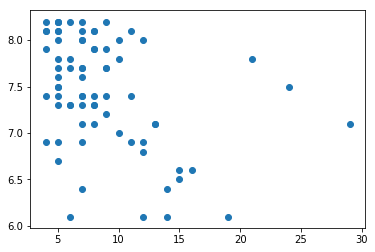

In [6]:
plt.scatter(df1.seasons, df1.rating)
plt.show()

The peak ratings seem to be at around the 5-7 seasons mark, but they also have some low ratings in that range as well.

What about comedy?

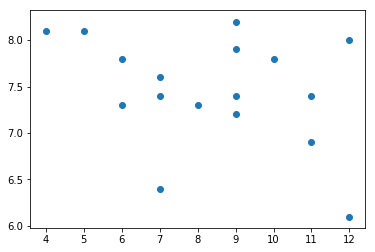

In [11]:
plt.scatter(comedy.seasons, comedy.rating)
plt.show()

### Some more in-depth analysis

Our dataframe is somewhat messy, especially with the "genre" column. The data doesn't distinguish Action & Adventure/Comedy from Comedy/Action & Adventure and there are too many variations of similar genres which would make analysis on genres too difficult. Let's fix that by assigning genre ids based on the "strongest" genre in a show's "genre" column.

In [12]:
def genre_id(genre):
    if "Animation" in genre:
        return 2
    if "Action" in genre and "Adventure" in genre:
        return 0
    if "Comedy" in genre and "Drama" in genre:
        return 1
    if "Comedy" in genre:
        return 3
    if "Crime" in genre and "Drama" in genre:
        return 4
    if "Fantasy" in genre or "Sci" in genre:
        return 5
    if "Drama" in genre:
        return 6
    return -1

In [13]:
genre_key = []
for x in df1.genres:
    genre_key.append(genre_id(x))
    
df1["genre_id"] = genre_key
df1.head()

,tv_id,rating,seasons,episodes,popularity,genres,genre_id
show,,,,,,,
Top Gear,45,7.5,24,176,33.498923,Documentary/Comedy/,3
That '70s Show,52,7.3,8,200,27.289507,Comedy/,3
Buffy the Vampire Slayer,95,8.0,7,144,20.664035,Comedy/Drama/Sci-Fi & Fantasy/,1
Weeds,186,7.1,8,102,18.432312,Drama/Comedy/,1
Star Trek: Enterprise,314,7.4,4,98,18.592752,Action & Adventure/Drama/Sci-Fi & Fantasy/,0


Now we can use the genre_id field to better model a show's predicted rating as a function of the number of seasons it has, its genre association, and its popularity on TMDb. We use the statmodel library's Ordinary Least Squares tool to generate all linear models from this point on

In [14]:
model = sm.OLS.from_formula('rating ~ seasons + genre_id + popularity + popularity * seasons * genre_id', data=df1)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     3.287
Date:                Fri, 15 Dec 2017   Prob (F-statistic):            0.00460
Time:                        06:34:27   Log-Likelihood:                -55.514
No. Observations:                  75   AIC:                             127.0
Df Residuals:                      67   BIC:                             145.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       7.8449      0.525     14.957      0.000       6.798       8.892
seasons                        -0.0280      0.072     -0.390      0.698      -0.172       0.115
genre_id                        0.0531      0.200      0.266      0.791      -0.346       0.452
popularity                     -0.0090      0.009     -1.001      0.321      -0.027       0.009
popularity:seasons              0.0008      0.001      0.705      0.483      -0.001       0.003
popularity:genre_id             0.0017      0.005      0.374      0.710      -0.007       0.011
seasons:genre_id               -0.0059      0.027     -0.220      0.827      -0.059       0.048
popularity:seasons:genre_id    -0.0003      0.001     -0.529      0.598      -0.001       0.001
==============================================================================
Omnibus:                        4.458   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                4.410
Skew:                          -0.557   Prob(JB):                        0.110
Kurtosis:                       2.587   Cond. No.                     1.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Predict a tv shows rating as a function of the number of seasons, its genre, and popularity. Let's add the predicted rating field to our dataframe

In [15]:
ols_predict = results.fittedvalues
df1["predicted_rating"] = ols_predict 
df1.head()

,tv_id,rating,seasons,episodes,popularity,genres,genre_id,predicted_rating
show,,,,,,,,
Top Gear,45,7.5,24,176,33.498923,Documentary/Comedy/,3,6.750459
That '70s Show,52,7.3,8,200,27.289507,Comedy/,3,7.525510
Buffy the Vampire Slayer,95,8.0,7,144,20.664035,Comedy/Drama/Sci-Fi & Fantasy/,1,7.583618
Weeds,186,7.1,8,102,18.432312,Drama/Comedy/,1,7.567429
Star Trek: Enterprise,314,7.4,4,98,18.592752,Action & Adventure/Drama/Sci-Fi & Fantasy/,0,7.623380


In linear regression, residuals are the difference between data's actual value and it's expected value. Let's calculate them and add them.

In [16]:
df1['ols_residuals'] = df1['rating'] - df1['predicted_rating']
df1.head()

,tv_id,rating,seasons,episodes,popularity,genres,genre_id,predicted_rating,ols_residuals
show,,,,,,,,,
Top Gear,45,7.5,24,176,33.498923,Documentary/Comedy/,3,6.750459,0.749541
That '70s Show,52,7.3,8,200,27.289507,Comedy/,3,7.525510,-0.225510
Buffy the Vampire Slayer,95,8.0,7,144,20.664035,Comedy/Drama/Sci-Fi & Fantasy/,1,7.583618,0.416382
Weeds,186,7.1,8,102,18.432312,Drama/Comedy/,1,7.567429,-0.467429
Star Trek: Enterprise,314,7.4,4,98,18.592752,Action & Adventure/Drama/Sci-Fi & Fantasy/,0,7.623380,-0.223380


Now we model a show's expected number of seasons as a function of user rating, it's genre, and popularity.

In [17]:
model = sm.OLS.from_formula('seasons ~ rating + genre_id + popularity + popularity * rating * genre_id', data=df1)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                seasons   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     3.785
Date:                Fri, 15 Dec 2017   Prob (F-statistic):            0.00162
Time:                        06:41:18   Log-Likelihood:                -209.09
No. Observations:                  75   AIC:                             434.2
Df Residuals:                      67   BIC:                             452.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     36.0550     32.413      1.112      0.270     -28.641     100.751
rating                        -3.7913      4.285     -0.885      0.379     -12.344       4.761
genre_id                      -2.3662      9.139     -0.259      0.796     -20.607      15.875
popularity                    -0.3411      0.558     -0.611      0.543      -1.455       0.773
popularity:rating              0.0488      0.075      0.648      0.519      -0.102       0.199
popularity:genre_id            0.0656      0.172      0.381      0.704      -0.278       0.409
rating:genre_id                0.2466      1.204      0.205      0.838      -2.157       2.651
popularity:rating:genre_id    -0.0067      0.023     -0.286      0.776      -0.053       0.040
==============================================================================
Omnibus:                       40.833   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.317
Skew:                           1.756   Prob(JB):                     2.03e-26
Kurtosis:                       8.053   Cond. No.                     8.01e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
ols_predict = results.fittedvalues
df1["predicted_seasons"] = ols_predict
df1.head()

,tv_id,rating,seasons,episodes,popularity,genres,genre_id,predicted_rating,ols_residuals,predicted_seasons
show,,,,,,,,,,
Top Gear,45,7.5,24,176,33.498923,Documentary/Comedy/,3,6.750459,0.749541,8.453809
That '70s Show,52,7.3,8,200,27.289507,Comedy/,3,7.525510,-0.225510,8.465755
Buffy the Vampire Slayer,95,8.0,7,144,20.664035,Comedy/Drama/Sci-Fi & Fantasy/,1,7.583618,0.416382,6.595649
Weeds,186,7.1,8,102,18.432312,Drama/Comedy/,1,7.567429,-0.467429,8.951229
Star Trek: Enterprise,314,7.4,4,98,18.592752,Action & Adventure/Drama/Sci-Fi & Fantasy/,0,7.623380,-0.223380,8.366738


In [19]:
df1["seasons_residuals"] = df1["seasons"] - df1["predicted_seasons"]
df1.head()

,tv_id,rating,seasons,episodes,popularity,genres,genre_id,predicted_rating,ols_residuals,predicted_seasons,seasons_residuals
show,,,,,,,,,,,
Top Gear,45,7.5,24,176,33.498923,Documentary/Comedy/,3,6.750459,0.749541,8.453809,15.546191
That '70s Show,52,7.3,8,200,27.289507,Comedy/,3,7.525510,-0.225510,8.465755,-0.465755
Buffy the Vampire Slayer,95,8.0,7,144,20.664035,Comedy/Drama/Sci-Fi & Fantasy/,1,7.583618,0.416382,6.595649,0.404351
Weeds,186,7.1,8,102,18.432312,Drama/Comedy/,1,7.567429,-0.467429,8.951229,-0.951229
Star Trek: Enterprise,314,7.4,4,98,18.592752,Action & Adventure/Drama/Sci-Fi & Fantasy/,0,7.623380,-0.223380,8.366738,-4.366738


### Some better visualization

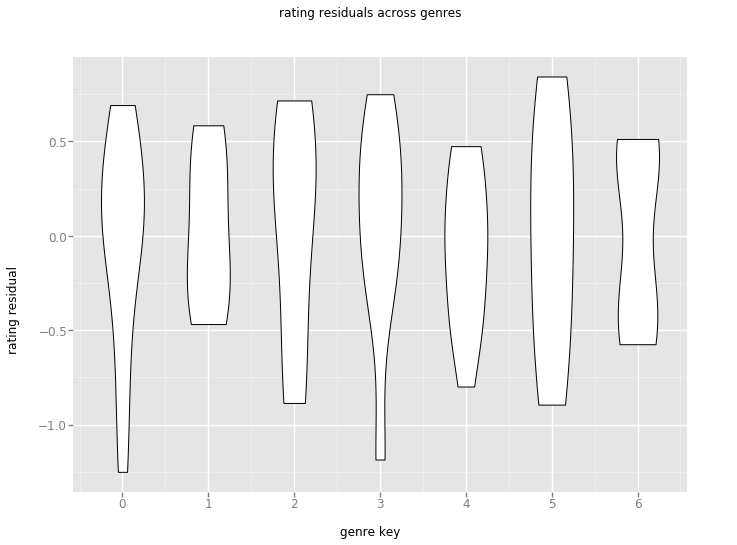

<ggplot: (-9223363242038628797)>

In [20]:
ggplot(aes(x='genre_id', y='ols_residuals'), data=df1) +\
    geom_violin() +\
    labs(title="rating residuals across genres",
         x = "genre key",
         y = "rating residual")

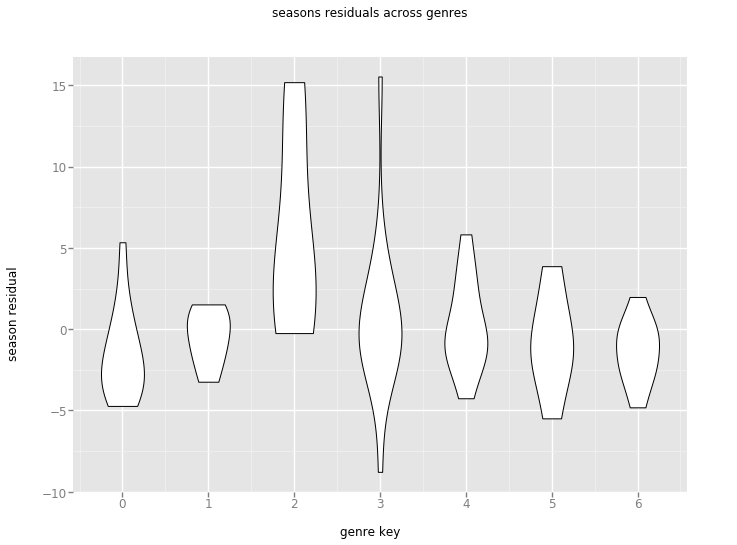

<ggplot: (8794816123691)>

In [21]:
ggplot(aes(x='genre_id', y='seasons_residuals'), data=df1) +\
    geom_violin() +\
    labs(title="seasons residuals across genres",
         x = "genre key",
         y = "season residual")

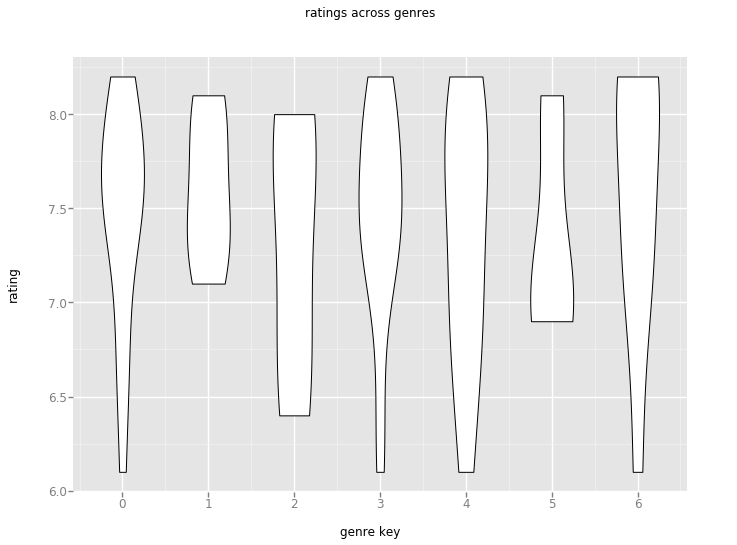

<ggplot: (8794816096723)>

In [22]:
ggplot(aes(x='genre_id', y='rating'), data=df1) +\
    geom_violin() +\
    labs(title="ratings across genres",
         x = "genre key",
         y = "rating")

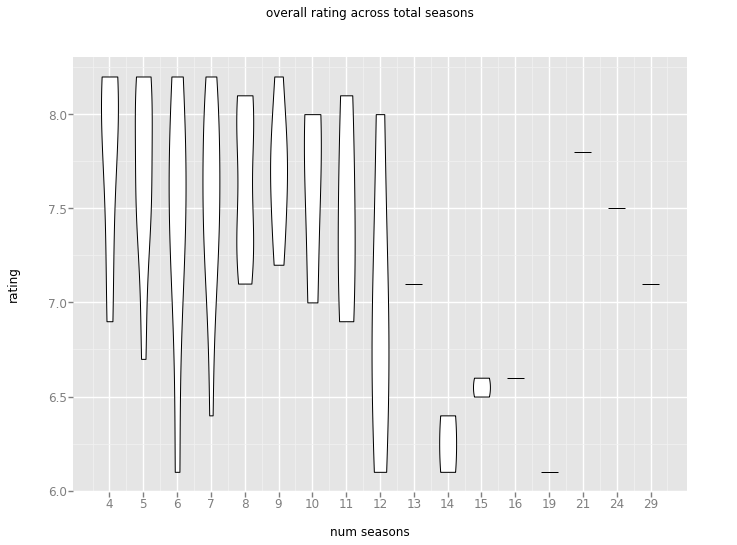

<ggplot: (8794816067795)>

In [23]:
ggplot(aes(x='seasons', y='rating'), data=df1) +\
    geom_violin() +\
    labs(title="overall rating across total seasons",
         x = "num seasons",
         y = "rating")

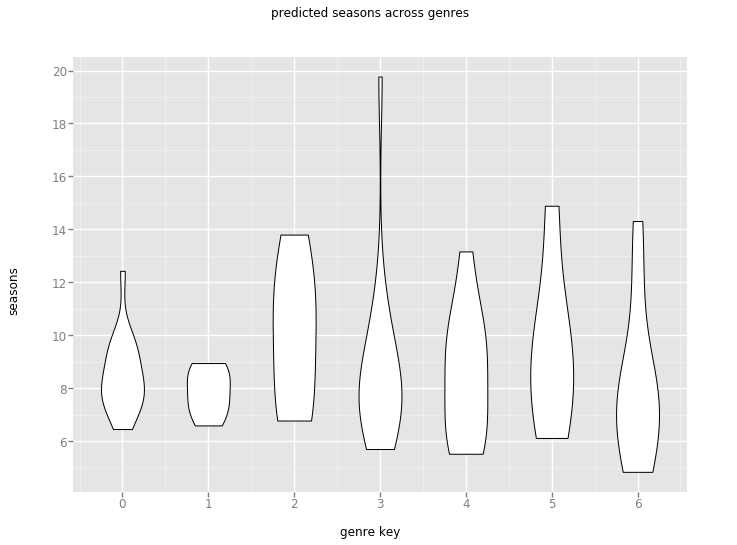

<ggplot: (-9223363242038949344)>

In [24]:
ggplot(aes(x='genre_id', y='predicted_seasons'), data=df1) +\
    geom_violin() +\
    labs(title="predicted seasons across genres",
         x = "genre key",
         y = "seasons")

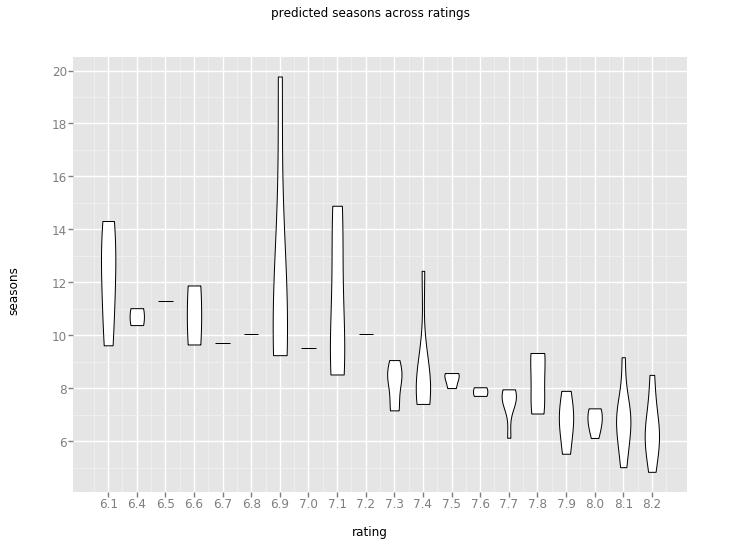

<ggplot: (-9223363242039359635)>

In [27]:
ggplot(aes(x='rating', y='predicted_seasons'), data=df1) +\
    geom_violin() +\
    labs(title="predicted seasons across ratings",
         x = "rating",
         y = "seasons")

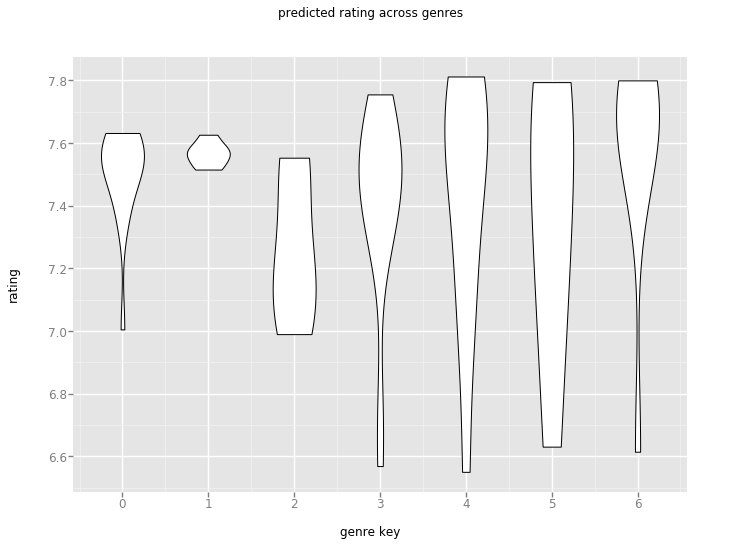

<ggplot: (8794815513124)>

In [28]:
ggplot(aes(x='genre_id', y='predicted_rating'), data=df1) +\
    geom_violin() +\
    labs(title="predicted rating across genres",
         x = "genre key",
         y = "rating")

Let's see how well our prediction models stack up against real life data and look and average rating across seasons/

In [29]:
simpsons = df1[df1["tv_id"] == 456]

In [30]:
simpsons

,tv_id,rating,seasons,episodes,popularity,genres,genre_id,predicted_rating,ols_residuals,predicted_seasons,seasons_residuals
show,,,,,,,,,,,
The Simpsons,456,7.1,29,688,142.196713,Animation/Comedy/,2,6.989866,0.110134,13.803118,15.196882


In [31]:
for x in range(1,30):
    season = tmdb.TV_Seasons(456, x)
    time.sleep(.251)
    info = season.info()

    try:
        curr = 0
        episodes = info.get("episodes")
        num = 0
        for ep in episodes:
            if ep.get("vote_count") > 0:
                curr += ep.get("vote_average")
                num += 1
        avg = curr / num
        key = "season" + str(x)
        simpsons[key] = avg
    except:
        pass

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [32]:
simpsons

,tv_id,rating,seasons,episodes,popularity,genres,genre_id,predicted_rating,ols_residuals,predicted_seasons,...,season20,season21,season22,season23,season24,season25,season26,season27,season28,season29
show,,,,,,,,,,,,,,,,,,,,,
The Simpsons,456,7.1,29,688,142.196713,Animation/Comedy/,2,6.989866,0.110134,13.803118,...,7.058714,6.130391,6.890182,6.822,6.492409,6.924909,6.865864,6.874136,6.206409,5.75


In [33]:
x = []
y = []
for i in range(1,30):
    x.append(i)
    key = "season" + str(i)
    y.append(simpsons[key][0])

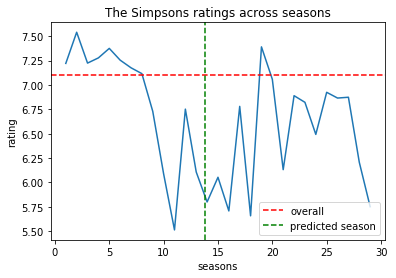

In [34]:
plt.plot(x,y)
#rating = np.array( [simpsons["rating"] for i in range(len(x))] )
overall = plt.axhline(y=simpsons["rating"][0], color='r', linestyle='--', label='overall')
vert = plt.axvline(x=simpsons["predicted_seasons"][0], color='g', linestyle='--', label ='predicted season')
plt.legend(handles=[overall,vert], loc=4)
plt.xlabel("seasons")
plt.ylabel("rating")
plt.title("The Simpsons ratings across seasons")
plt.show()

Season 13/14 of the simpsons certainly was a relative low for the show, maybe it stayed past it's welcome

### Conclusion: How did our hypothesis test out?

From the data and the tests we ran, it seems that our hypothesis was relatively accurate. Comedies and action shows tend to have lower ratings and run longer than other more serious genres, while those genres will typically have higher user ratings. This may be because as comedy and action shows become popular, the networks see them as a safe bet to be successful and continually renew them; at the risk of having the shows become less unique than previous seasons and an overall drop in quality.

# Part 2 
## Does the age of a cast influence ratings?

This section of the tutorial tests if and how the age of a cast influences reviews of movies. Like the previous section, the data is gathered from tmdb using their api and one of tmdb's api wrappers called tmdb simple. We hypothesize that older casts will tend to have higher reviews, since more experience may translate to better performances. We will test this hypothesis with the following steps:

1. Gathering data on movies with more than 200 votes
2. Cleaning and organizing the data in a pandas table 
3. Plotting and analyzing lines of best fit

## Data Gathering


#### Challenges
The data gathering process for movies on tmdb presented two main challenges: the unknown id's of movies and the rate limited api. The movie endpoint on tmdb requires a movieId parameter, but tmdb does not have any published list of id's. This means that we needed to iterate through every possible movie id until we reached the most recently added movie. 

The movie id's range from 0 to around 500,000. Unfortunately, there are many indicies that do not correspond to any movie, so there are tens of thousands of invalid movie id's. This made it necessary to use try statements when accessing the return value for all the api calls. Given that we needed to iterate through 500,000, the 240/min api rate limit caused the gathering process to take around 48 hours. 

Getting the ages of the actors required using tmdb's person endpoint, with the personId's gathered from the movie's cast list.

#### Approach
For the actual movie data we recorded, we only wanted data about movies with more than 200 votes. Otherwise, the ratings may not be so reliable. We also wanted to considered that there may be differences when dealing with the average age of the top 10, 6, 3 and lead role, so we calculated these data points in the tsv file. Overall, the tsv contains the following data points: title of movie, rating of movie (scale 1 to 10), release data, and the average age of the top 10, 6, 3, and 1 actors. The "top" actors are defined by the order that they appear in the cast list for each movie. 

Note that we use -1 for the average age when the group is not complete (if there are 5 actors listed, age_6 will be -1 but age_3 will be recorded).

The following functions were used to collect the data described above, which would be appended to the tsv. 

In [ ]:
# This code was only run once to initialize the tsv

#with open("output.tsv", "w") as f:
#    print ("\t%s\t%s\t%s\t%s\t%s\t%s\t%s" % ("movie", "rating", "release", "age_10", "age_6", "age_3", "age_1"), file=f)

In [ ]:
# write a line to the tsv
def saveLine(index, movie, rating, release, age_10, age_6, age_3, age_1):
    with open("output.tsv", "a") as f:
        print ("%d\t%s\t%s\t%s\t%s\t%s\t%s\t%s" % (index, movie, rating, release, age_10, age_6, age_3, age_1), file=f)

In [ ]:
def getSingleAge(actID,release):
    person = tmdb.People(actID)
    try:
        bd = person.info().get('birthday')
        bd = parser.parse(bd)
        rl = parser.parse(release)
        delta = (rl - bd).days/365
        return round(delta,1)
    except:
        return -1
    
def getAges(actors,release,movieIndex,title,rating):
    age_10 = -1
    age_6 = -1
    age_3 = -1
    age_1 = -1
    ages = []

    q = len(actors)
    for x in range(q):
        time.sleep(.25)
        
        try:
            c = getSingleAge(actors[x].get('id'),release)
            if(c > 1):
                ages.append(c)
        except:
            ages = ages
    if(len(ages) > 9):
        age_10 = sum(ages)/10
    if(len(ages) > 5):
        age_6 = sum(ages[:6])/6
    if(len(ages) > 2):
        age_3 = sum(ages[:3])/3
    if(len(ages) > 0):
        age_1 = ages[0]
    saveLine(movieIndex,title,rating, release, age_10, age_6, age_3, age_1)

    
movieIndex = 500000

while(movieIndex < 500000):
    movie = tmdb.Movies(movieIndex)
    time.sleep(.25)
    actors = []
    try:
        info = movie.info()
        title = info.get('title')
        votes = info.get('vote_count')
        print(votes)
        if((int(votes) > 200) and hasattr(movie,'credits')):
            print('working')
            release = info.get('release_date')
            actors = movie.credits().get('cast')
            rating = info.get('vote_average')
            if(len(actors) > 9):
                actors = actors[:10]
            elif(len(actors) > 5):
                actors = actors[:6]
            elif(len(actors) > 2):
                actors = actors[:3]
            elif(len(actors) > 0):
                actors = actors[:1]
                
    except:
        print("Not valid")
        
    if(len(actors) > 0):
        getAges(actors,release,movieIndex,title,rating)

    print(movieIndex)
    movieIndex += 1

### Dataframe 
Here's a sample of the 4200 rows of data that was collected. We use drop duplicates since there were a few duplicates from human error (not using the right index between gathering sessions).

In [114]:
# load dataframe from tsv 
ageData = pd.DataFrame.from_csv("output.tsv", sep='\t').drop_duplicates()
ageData.head()

,movie,rating,release,age_10,age_6,age_3,age_1
5,Four Rooms,6.5,1995-12-09,32.81,35.183333,34.000000,34.6
11,Star Wars,8.1,1977-05-25,40.38,39.950000,27.066667,25.7
12,Finding Nemo,7.6,2003-05-30,44.63,40.850000,36.800000,55.9
13,Forrest Gump,8.3,1994-07-06,-1.00,33.450000,35.200000,38.0
14,American Beauty,7.9,1999-09-15,35.55,31.466667,33.000000,40.2


## Age vs Reviews

Now let's have a quick look at the age-review relationships with some scatterplots with best fit lines. A 3 degree polynomial should be able to show us any important changes without too much overfitting.

#### Lead Role (age_1)

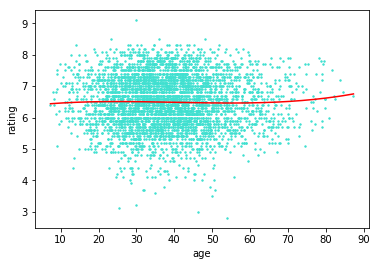

In [102]:
temp = ageData.query('age_1 > 0')
plt.ylabel('rating')
plt.xlabel('age')
plt.plot(np.unique(temp.age_1), np.poly1d(np.polyfit(temp.age_1, temp.rating, 3))(np.unique(temp.age_1)), c="red")
plt.scatter(temp.age_1, temp.rating, s=2, c="turquoise")
plt.show()

#### Top 3  Actors (age_3)

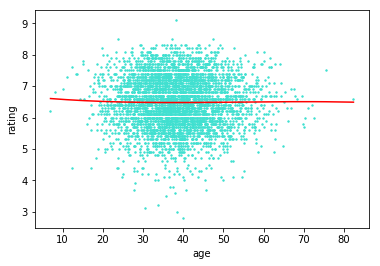

In [103]:
temp = ageData.query('age_3 > 0')
plt.ylabel('rating')
plt.xlabel('age')
plt.plot(np.unique(temp.age_3), np.poly1d(np.polyfit(temp.age_3, temp.rating, 3))(np.unique(temp.age_3)), c="red")
plt.scatter(temp.age_3, temp.rating, s=2, c="turquoise")
plt.show()

#### Top 6 Actors (age_6)

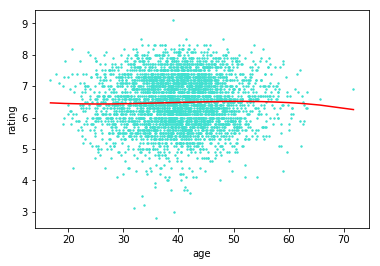

In [104]:
temp = ageData.query('age_6 > 0')
plt.ylabel('rating')
plt.xlabel('age')
plt.plot(np.unique(temp.age_6), np.poly1d(np.polyfit(temp.age_6, temp.rating, 3))(np.unique(temp.age_6)), c="red")
plt.scatter(temp.age_6, temp.rating, s=2, c="turquoise")
plt.show()

#### Top 10 Actors (age_10)

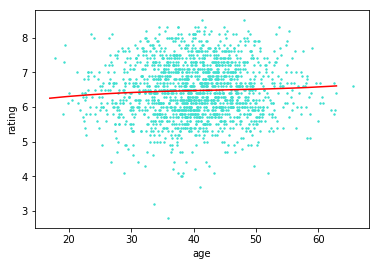

In [105]:
temp = ageData.query('age_10 > 0')
plt.ylabel('rating')
plt.xlabel('age')
plt.plot(np.unique(temp.age_10), np.poly1d(np.polyfit(temp.age_10, temp.rating, 3))(np.unique(temp.age_10)), c="red")
plt.scatter(temp.age_6, temp.rating, s=2, c="turquoise")
plt.show()

### Going by the looks
By the pure look of the scatter plots and the trendline, there's no clear correlation. The data points look fairly evenly distributed around an average cast age of 40 and rating of 6.5.  

### Going by the numbers
Let's see if there is any slope at all in the one-degree polynomial lines.

In [115]:
print("Lead slope:")
print(np.poly1d(np.polyfit(temp.age_1, temp.rating, 1))[1])
print("Top 3 slope:")
print(np.poly1d(np.polyfit(temp.age_3, temp.rating, 1))[1])
print("Top 6 slope:")
print(np.poly1d(np.polyfit(temp.age_6, temp.rating, 1))[1])
print("Top 10 slope:")
print(np.poly1d(np.polyfit(temp.age_10, temp.rating, 1))[1])

Lead slope:
-0.00181079482964
Top 3 slope:
-0.00139562318732
Top 6 slope:
0.00318308057983
Top 10 slope:
0.00495935772605


## How did our hypothesis do?

After this analysis, it seems that our hypothesis is wrong and older actors don't make better movies after all. However, one interesting takeaway is that the scatterplots have somewhat smooth distributions. While we can't prove our hypothesis, we can still deliver some fun facts...

## Fun facts
### Average ages of top cast members...todo